In [1]:
import pandas as pd
import numpy as np
import yfinance as yfin
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from datetime import datetime
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt

In [2]:
def carregarDados(ticket, start_date, end_date):
    data = yfin.download(tickers=ticket, start=start_date, end=end_date)
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(data['Adj Close'].values.reshape(-1,1))
    return data, scaled_data, scaler

In [3]:
def prepararDadosTreinamento(scaled_data, days):
    x_train, y_train = [], []
    for i in range(days, len(scaled_data)):
        x_train.append(scaled_data[i-days:i, 0])
        y_train.append(scaled_data[i, 0])
    return np.array(x_train).reshape(-1, days, 1), np.array(y_train)


In [4]:
def modeloLSTM(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(units=50, return_sequences=True),
        Dropout(0.2),
        LSTM(units=50),
        Dropout(0.2),
        Dense(units=1)
    ])
    return model

In [5]:
def build_model(hp):
    model = Sequential()
    
    n_layers = hp.Int('n_layers', min_value=1, max_value=2)
    
    for i in range(n_layers):
        units = hp.Int(f'units_{i}', min_value=32, max_value=256, step=64)
        
        model.add(LSTM(
            units=units,
            return_sequences=(i < n_layers - 1),
            input_shape=(lookback, n_features) if i == 0 else None
        ))
        
        dropout_rate = hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.2)
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1))

    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-3, sampling='log')
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                 loss='mse')
    
    return model

In [6]:
def treinarModelo(model, x_train, y_train, epochs=25, batch_size=32):
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    return model

In [7]:
def avaliarModelo(model, x_test, y_test, scaler):
    predicted_scaled = model.predict(x_test)
    predicted = scaler.inverse_transform(predicted_scaled)
    actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)
    
    return mae, mse, rmse, r2, actual, predicted

In [8]:
def plotarESalvarGrafico(actual, predicted, ticket, days, fold):
    plt.plot(actual, color='black', label=f'Preços Reais da {ticket}')
    plt.plot(predicted, color='green', label=f'Preços Previstos da {ticket}')
    plt.title(f'{ticket} - Janela: {days} dias - Fold: {fold+1}')
    plt.xlabel('Tempo')
    plt.ylabel(f'{ticket}')
    plt.legend()
    plt.savefig(f'prediction_plot_{days}_days_fold_{fold+1}.png')
    plt.show()

In [9]:
def salvarResultadosCSV(resultados, filename='model_performance_with_hyperparams.csv'):
    all_results_df = pd.DataFrame(resultados)
    
    summary_df = all_results_df.groupby('Days').agg({
        'Avg MAE': 'mean',
        'Avg MSE': 'mean',
        'Avg RMSE': 'mean',
        'Avg R²': 'mean'
    }).reset_index()
    
    all_results_df.to_csv(filename, index=False)
    
    summary_df.to_csv('summary_' + filename, index=False)

In [10]:
def executarModelo(ticket, data, scaled_data, scaler, max_days=21):
    all_fold_results = []
    tscv = TimeSeriesSplit(n_splits=5)
    
    for days in range(1, max_days):
        x_train, y_train = prepararDadosTreinamento(scaled_data, days)
        
        global lookback, n_features
        lookback = days
        n_features = 1
        
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=8,  
                restore_best_weights=True
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=5 
            )
        ]
        
        fold_mae, fold_mse, fold_rmse, fold_r2 = [], [], [], []
        
        for fold, (train_idx, test_idx) in enumerate(tscv.split(x_train)):
            x_train_fold, x_val_fold = x_train[train_idx], x_train[test_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[test_idx]
            
            tuner = kt.RandomSearch(
                build_model,
                objective='val_loss',
                max_trials=20,
                executions_per_trial=3,  
                directory=f'tuner_results_{days}days_fold{fold}',
                project_name=f'lstm_tuning_{ticket}'
            )
            
            tuner.search(
                x_train_fold, y_train_fold,
                validation_data=(x_val_fold, y_val_fold),
                callbacks=callbacks,
                epochs=50, 
                batch_size=32,
                verbose=1
            )
            
            best_model = tuner.get_best_models(num_models=1)[0]
            mae, mse, rmse, r2, actual, predicted = avaliarModelo(
                best_model, x_val_fold, y_val_fold, scaler
            )
            
            fold_mae.append(mae)
            fold_mse.append(mse)
            fold_rmse.append(rmse)
            fold_r2.append(r2)
            
            plotarESalvarGrafico(actual, predicted, ticket, days, fold)
            
            best_hps = tuner.get_best_hyperparameters(1)[0]
            
            all_fold_results.append({
                'Days': days,
                'Fold': fold+1,
                'Avg MAE': np.mean(fold_mae),
                'Avg MSE': np.mean(fold_mse),
                'Avg RMSE': np.mean(fold_rmse),
                'Avg R²': np.mean(fold_r2),
                'Best Learning Rate': best_hps.get('learning_rate'),
                'Number of Layers': best_hps.get('n_layers'),
                'Units Layer 0': best_hps.get('units_0'),
                'Dropout Rate 0': best_hps.get('dropout_0'),
                'Units Layer 1': best_hps.get('units_1') if best_hps.get('n_layers') > 1 else None,
                'Dropout Rate 1': best_hps.get('dropout_1') if best_hps.get('n_layers') > 1 else None
            })
    
    salvarResultadosCSV(all_fold_results)

Trial 20 Complete [00h 03m 50s]
val_loss: 0.0009586086380295455

Best val_loss So Far: 0.0006104756224279603
Total elapsed time: 01h 00m 50s
 1/21 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step

c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


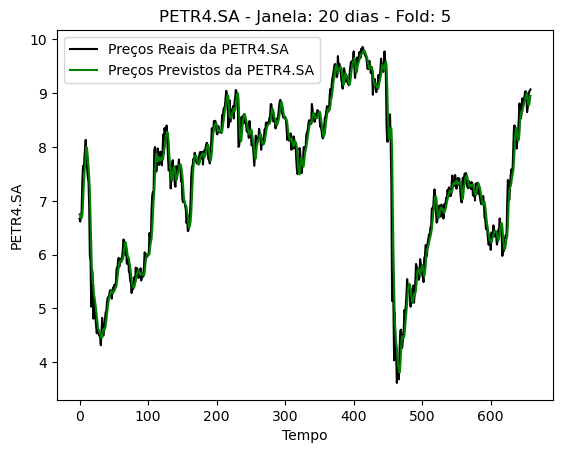

In [11]:
ticket = "PETR4.SA"
data, scaled_data, scaler = carregarDados(ticket, start_date=datetime(2005, 1, 1), end_date=datetime(2021, 1, 1))
executarModelo(ticket, data, scaled_data, scaler)

### róximos passos:

- Fechar experimentos sem indicadores.
- Fazer experimentos com todos os indicadores.
- Definir a heurística de seleção de indicadores.
- Fazer experimentos com os indicadores selecionados.
- Estratégia de investimento.